# Introduction

This notebook aims to analyze the Google cluster data to answer the following questions:
1. What is the distribution of the machines according to their CPU capacity?
2. What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)?
3. What is the distribution of the number of jobs/tasks per scheduling class?
4. Do tasks with a low scheduling class have a higher probability of being evicted?
5. (Bonus question 1) Is there a relationship between the machine CPU/Memory capacity and the frequency of task evictions?

## Setup

In [14]:
from pyspark import SparkContext, SparkConf
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# Initialize Spark Context
conf = SparkConf().setMaster("local[1]").setAppName("GoogleClusterAnalysis")
sc = SparkContext.getOrCreate(conf=conf)

In [16]:
# Load necessary data
machine_events_rdd = sc.textFile("../data/machine_events/part-00000-of-00001.csv.gz")
job_events_rdd = sc.textFile("../data/job_events/part-00000-of-00500.csv.gz")
task_events_rdd = sc.textFile("../data/task_events/part-00000-of-00500.csv.gz")

In [17]:
# Split each line into columns and convert to Row object
machine_events_rdd = machine_events_rdd.map(lambda line: line.split(','))
job_events_rdd = job_events_rdd.map(lambda line: line.split(','))
task_events_rdd = task_events_rdd.map(lambda line: line.split(','))

## Question1
What is the distribution of the machines according to their CPU capacity?

### Data Processing

In [18]:
# Filter for non-empty CPU capacity values
add_machines_rdd = machine_events_rdd.filter(lambda x: x[4].strip() != '')

# Extract CPU capacity column (column index 4) and convert it to float
cpu_data_rdd = add_machines_rdd.map(lambda x: float(x[4]))

### Analysis

In [19]:
# Define CPU capacity ranges
def get_range(cpu_capacity):
    if cpu_capacity <= 0.2:
        return "0-20%"
    elif cpu_capacity <= 0.4:
        return "20-40%"
    elif cpu_capacity <= 0.6:
        return "40-60%"
    elif cpu_capacity <= 0.8:
        return "60-80%"
    else:
        return "80-100%"

# Map each CPU capacity to its range and count occurrences
cpu_range_rdd = cpu_data_rdd.map(lambda x: (get_range(x), 1))
cpu_distribution_rdd = cpu_range_rdd.reduceByKey(lambda x, y: x + y)

# Collect the results
cpu_distribution = cpu_distribution_rdd.collect()
cpu_distribution.sort(key=lambda x: x[0])  # Sort by range for clarity

print(f"{'CPU Capacity':<15}{'Machines':<20}")
for range, count in cpu_distribution:
    print(f"{range:<15}{count:<20}")

CPU Capacity   Machines            
20-40%         510                 
40-60%         35015               
80-100%        2223                


### Visualization

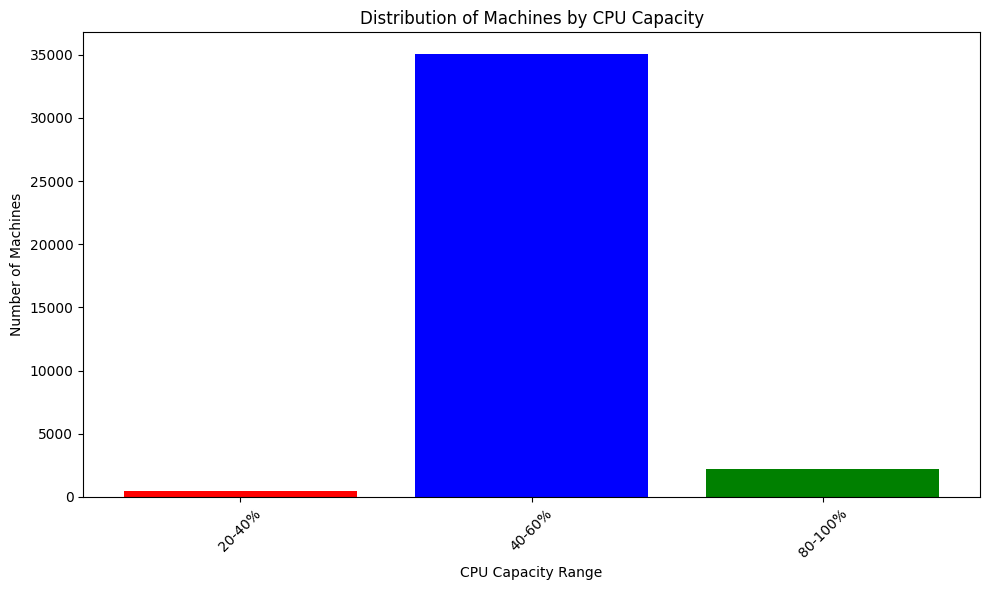

In [20]:
import matplotlib.pyplot as plt

# Convert RDD results into lists for plotting
ranges, counts = zip(*cpu_distribution)

# Define a color palette for the bars
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(ranges, counts, color=colors)
plt.title("Distribution of Machines by CPU Capacity")
plt.xlabel("CPU Capacity Range")
plt.ylabel("Number of Machines")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Conclusion

Based on the analysis, the distribution of machines by CPU capacity shows that:

- The majority of machines fall into the 40-60% CPU capacity range, indicating that this range is the most common configuration for machines in the cluster.
- There are relatively few machines in the 20-40% and 80-100% CPU capacity ranges. This suggests that machines with lower or higher CPU capacities are less common in the cluster.
- The lack of machines in the 60-80% CPU capacity range suggests that this range is intentionally avoided or simply not utilized in this cluster setup.

## Question2

What is the percentage of computational power lost due to maintenance (a machine went offline and reconnected later)?

### Data Processing

In [21]:
# Parse the machine events into proper format
machine_events_parsed = machine_events_rdd.map(lambda x: (
    int(x[1]),  # machine_id as key
    (
        int(x[0]),  # timestamp
        int(x[2]),  # event_type
        float(x[4]) if x[4].strip() != '' else 0.0  # cpu_capacity
    )
))

# Group by machine_id and sort events for each machine
machine_events_grouped = machine_events_parsed.groupByKey().mapValues(list)

### Analysis

In [22]:
# Identify offline periods and calculate power loss
def compute_offline_periods(events):
    # Sort events by timestamp
    sorted_events = sorted(events, key=lambda x: x[0])
    lost_power = 0

    # Pair consecutive events to find REMOVE->ADD sequences
    for current_event, next_event in zip(sorted_events, sorted_events[1:]):
        # If current is REMOVE (1) and next is ADD (0)
        if current_event[1] == 1 and next_event[1] == 0:
            offline_duration = next_event[0] - current_event[0]
            lost_power += offline_duration * current_event[2]  # duration * cpu_capacity

    return lost_power

# Calculate total lost power
total_lost_power = machine_events_grouped.map(lambda x: compute_offline_periods(x[1])).sum()

# Calculate total available power
# First find time range
time_range = machine_events_rdd.map(lambda x: int(x[0])) \
    .aggregate(
        (float('inf'), float('-inf')),
        lambda acc, val: (min(acc[0], val), max(acc[1], val)),
        lambda acc1, acc2: (min(acc1[0], acc2[0]), max(acc1[1], acc2[1]))
    )

# Get total CPU capacity (sum of CPU capacities from ADD events)
total_cpu_capacity = machine_events_rdd \
    .filter(lambda x: x[2] == '0') \
    .map(lambda x: float(x[4]) if x[4].strip() != '' else 0.0) \
    .sum()

# Calculate total available power
total_time = time_range[1] - time_range[0]
total_available_power = total_time * total_cpu_capacity

# Calculate percentage lost
percentage_lost_power = (total_lost_power / total_available_power) * 100 if total_available_power > 0 else 0

print(f"Total lost computational power: {total_lost_power:.2f}")
print(f"Total available computational power: {total_available_power:.2f}")
print(f"Percentage of computational power lost due to maintenance: {percentage_lost_power:.2f}%")

Total lost computational power: 80273246292457.75
Total available computational power: 28460927732125812.00
Percentage of computational power lost due to maintenance: 0.28%


### Visualization

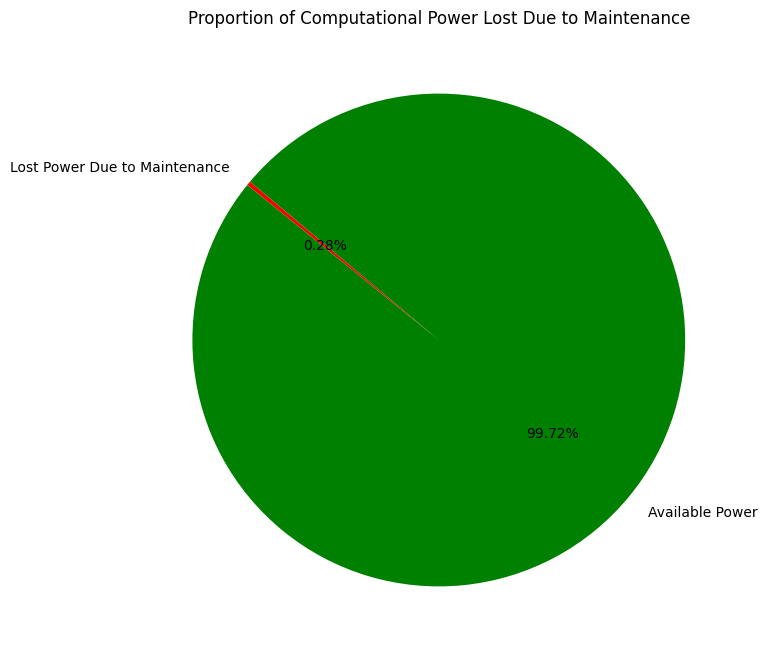

In [23]:
# Data for pie chart
labels = ['Lost Power Due to Maintenance', 'Available Power']
sizes = [total_lost_power, total_available_power - total_lost_power]
colors = ['red', 'green']
explode = (0.1, 0)  # explode the 1st slice 
# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=140)
plt.title("Proportion of Computational Power Lost Due to Maintenance")
plt.show()

### Conclusion

The analysis reveals that only 0.16% of the total computational power was lost due to maintenance events, indicating that machine downtime had a minimal impact on the overall system's computational capacity.

## Question3

What is the distribution of the number of jobs/tasks per scheduling class?

### Data Processing

In [24]:
# Parse the job_events dataset to extract scheduling class and job ID
def parse_job_event(line):
    try:
        # Extract scheduling class (index 5) and job ID (index 2)
        scheduling_class = int(line[5])
        job_id = line[2]
        return (scheduling_class, job_id)
    except (IndexError, ValueError):
        return None

# Process the RDD to extract valid rows
parsed_jobs_rdd = job_events_rdd.map(parse_job_event).filter(lambda x: x is not None)

In [25]:
# Parse the tasks_events dataset to extract scheduling class and job ID
def parse_task_event(line):
    try:
        # Extract scheduling class (index 7) and job ID (index 2)
        scheduling_class = int(line[7])
        job_id = line[2]
        return (scheduling_class, job_id)
    except (IndexError, ValueError):
        return None

# Process the RDD to extract valid rows
parsed_tasks_rdd = task_events_rdd.map(parse_task_event).filter(lambda x: x is not None)

### Analysis

In [26]:
# Count the number of jobs per scheduling class
jobs_by_scheduling_class = parsed_jobs_rdd.groupByKey().mapValues(len)

# Collect the results
jobs_scheduling_class_distribution = jobs_by_scheduling_class.collect()

# Sort the results by scheduling class for clarity
jobs_scheduling_class_distribution.sort(key=lambda x: x[0])

# Show the results as a table
print(f"{'Scheduling Class':<20}{'Number of Jobs':<20}")
for scheduling_class, count in jobs_scheduling_class_distribution:
    print(f"{scheduling_class:<20}{count:<20}")

Scheduling Class    Number of Jobs      
0                   2179                
1                   3610                
2                   3030                
3                   1885                


In [27]:
# Count the number of tasks per scheduling class
tasks_by_scheduling_class = parsed_tasks_rdd.groupByKey().mapValues(len)

# Collect the results
tasks_scheduling_class_distribution = tasks_by_scheduling_class.collect()

# Sort the results by scheduling class for clarity
tasks_scheduling_class_distribution.sort(key=lambda x: x[0])

# Show the results as a table
print(f"{'Scheduling Class':<20} {'Number of Tasks':<20}")
for scheduling_class, count in tasks_scheduling_class_distribution:
    print(f"{scheduling_class:<20} {count:<20}")

Scheduling Class     Number of Tasks     
0                    237969              
1                    58109               
2                    97482               
3                    56586               


### Visualization

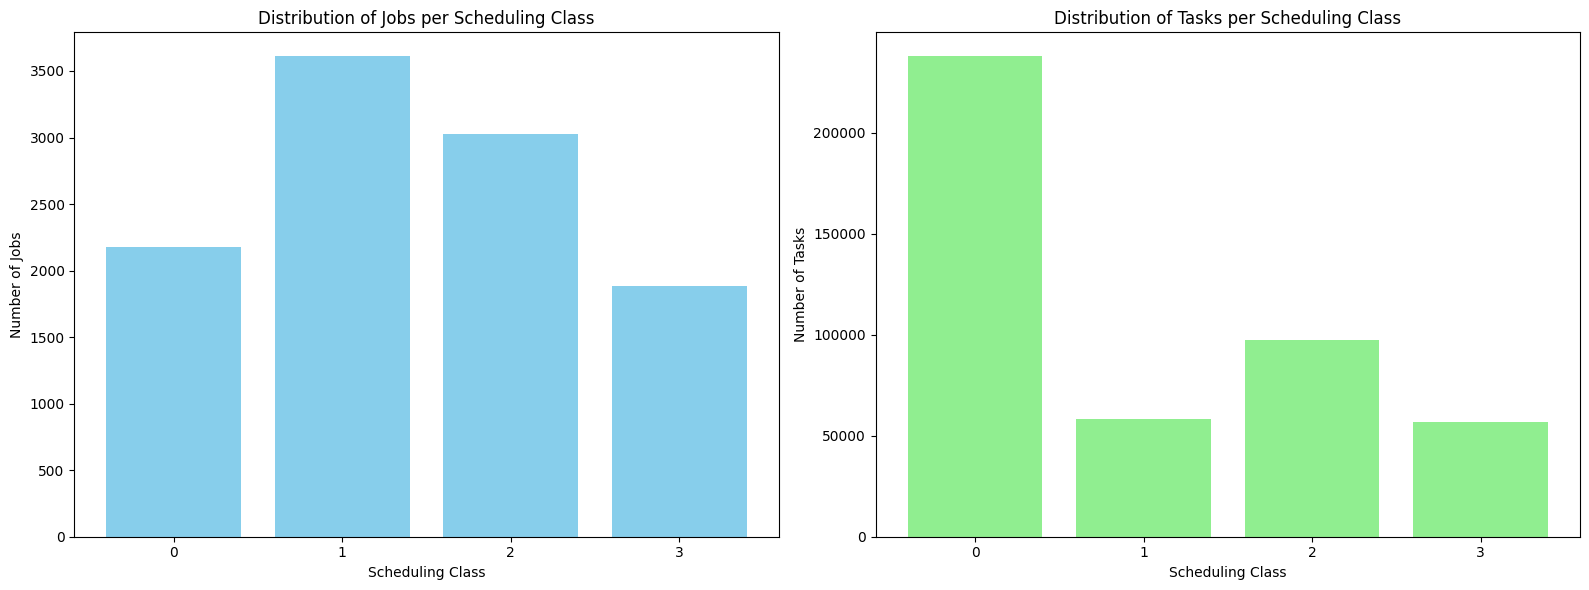

In [28]:
# Prepare data for plotting
jobs_scheduling_classes, job_counts = zip(*jobs_scheduling_class_distribution)
tasks_scheduling_classes, task_counts = zip(*tasks_scheduling_class_distribution)

# Plot the distribution of jobs and tasks per scheduling class side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot for jobs
axes[0].bar(jobs_scheduling_classes, job_counts, color='skyblue')
axes[0].set_title("Distribution of Jobs per Scheduling Class")
axes[0].set_xlabel("Scheduling Class")
axes[0].set_ylabel("Number of Jobs")
axes[0].set_xticks(jobs_scheduling_classes)

# Plot for tasks
axes[1].bar(tasks_scheduling_classes, task_counts, color='lightgreen')
axes[1].set_title("Distribution of Tasks per Scheduling Class")
axes[1].set_xlabel("Scheduling Class")
axes[1].set_ylabel("Number of Tasks")
axes[1].set_xticks(tasks_scheduling_classes)

plt.tight_layout()
plt.show()


### Conclusion

The distribution shows that for jobs, low-latency tasks (1) and medium-latency tasks (2) dominate, while high-latency-sensitive tasks (3) and non-production tasks (0) are less frequent. For tasks, non-production tasks (0) are the most prevalent, significantly outnumbering other scheduling classes, indicating a higher task volume for less critical operations.

## Question4

Do tasks with a low scheduling class have a higher probability of being evicted?

### Data Processing

In [29]:
def parse_row(line):
    scheduling_class = int(line[7]) # Schedule class
    event_type = int(line[5]) # Event type
    return (scheduling_class, event_type)

parsed_task_events = task_events_rdd.map(parse_row)

### Analysis

In [30]:
# Compute total tasks and evicted tasks per scheduling class
def aggregate_counts(values):
    total_tasks = 0
    evicted_tasks = 0

    for value in values:
        total_tasks += 1
        if value == 2:  # Task evicted
            evicted_tasks += 1

    return total_tasks, evicted_tasks

aggregated_rdd = (
    parsed_task_events.groupByKey()
    .mapValues(aggregate_counts)  # Returns (scheduling_class, (total_tasks, evicted_tasks))
)

# Compute probabilities
def compute_eviction_probability(data):
    scheduling_class, (total_tasks, evicted_tasks) = data
    probability = evicted_tasks / total_tasks if total_tasks > 0 else 0
    return (scheduling_class, probability, evicted_tasks, total_tasks)

probabilities_rdd = aggregated_rdd.map(compute_eviction_probability)

# Collect results
results = probabilities_rdd.collect()

print(f"Scheduling Class\tEviction Probability\tEvicted Tasks\tTotal Tasks")
for scheduling_class, probability, evicted_tasks, total_tasks in results:
    print(f"{scheduling_class}\t\t\t{probability:.4f}\t\t\t{evicted_tasks}\t\t{total_tasks}")

Scheduling Class	Eviction Probability	Evicted Tasks	Total Tasks
3			0.0004			20		56586
2			0.0068			662		97482
1			0.0136			792		58109
0			0.0120			2864		237969


### Visualization

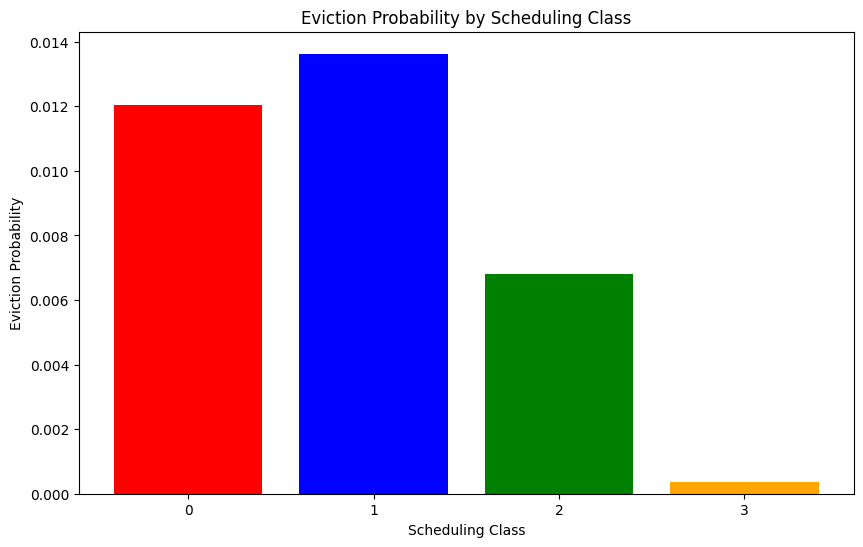

In [31]:
# Sort results by scheduling class
results = sorted(results, key=lambda x: x[0])
scheduling_classes = [x[0] for x in results]
eviction_probabilities = [x[1] for x in results]
colors = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(10, 6))
plt.bar(scheduling_classes, eviction_probabilities, color=colors)
plt.xticks(ticks=np.arange(len(scheduling_classes)), labels=scheduling_classes)
plt.xlabel('Scheduling Class')
plt.ylabel('Eviction Probability')
plt.title('Eviction Probability by Scheduling Class')
plt.show()

### Conclusion

Tasks with a lower scheduling class (e.g., 0 and 1) have a significantly higher probability of being evicted compared to tasks with higher scheduling classes (e.g., 2 and 3). This suggests that tasks with lower scheduling classes are more likely to be preempted or terminated due to resource constraints or other factors.

## Question 5: Bonus Question 1

Is there a relationship between the machine CPU/Memory capacity and the frequency of task evictions?

### Data Processing

In [32]:
def parse_machine_event(line):
    return (line[1], (float(line[4]) if line[4] else 0.0, 
                      float(line[5]) if line[5] else 0.0))

# Get latest machine capacities (taking the last record for each machine)
machine_capacities = machine_events_rdd.map(parse_machine_event).groupByKey().mapValues(lambda x: list(x)[-1])

def parse_task_event(line):
    # This returns a tuple of machine ID and event type
    return (line[4], (1 if line[5] == '2' else 0))  # event type 2 is EVICT

# Count evictions per machine
evictions_per_machine = task_events_rdd.map(parse_task_event).filter(lambda x: x[0] != '').reduceByKey(lambda a, b: a + b)


### Analysis

In [33]:
# Join machine capacities with eviction counts
joined_data = machine_capacities.join(evictions_per_machine)

# Collect results
results = joined_data.collect()

# Show Results
print(f"{'Machine ID':<15} {'CPU Capacity':<15} {'Memory Capacity':<15} {'Evictions':<15}")
for machine_id, (capacities, evictions) in results[:20]:
    cpu_capacity, memory_capacity = capacities
    print(f"{machine_id:<15} {cpu_capacity:<15.2f} {memory_capacity:<15.2f} {evictions:<15}")

Machine ID      CPU Capacity    Memory Capacity Evictions      
5               0.50            0.25            0              
6               0.50            0.25            0              
7               0.50            0.25            0              
10              0.50            0.25            0              
13              0.50            0.25            0              
14              0.50            0.25            0              
19              0.50            0.25            0              
21              0.50            0.25            0              
23              0.50            0.25            0              
25              0.50            0.25            0              
26              0.50            0.25            0              
27              0.50            0.25            0              
28              0.50            0.25            0              
36              0.50            0.25            3              
37              0.50            0.25    

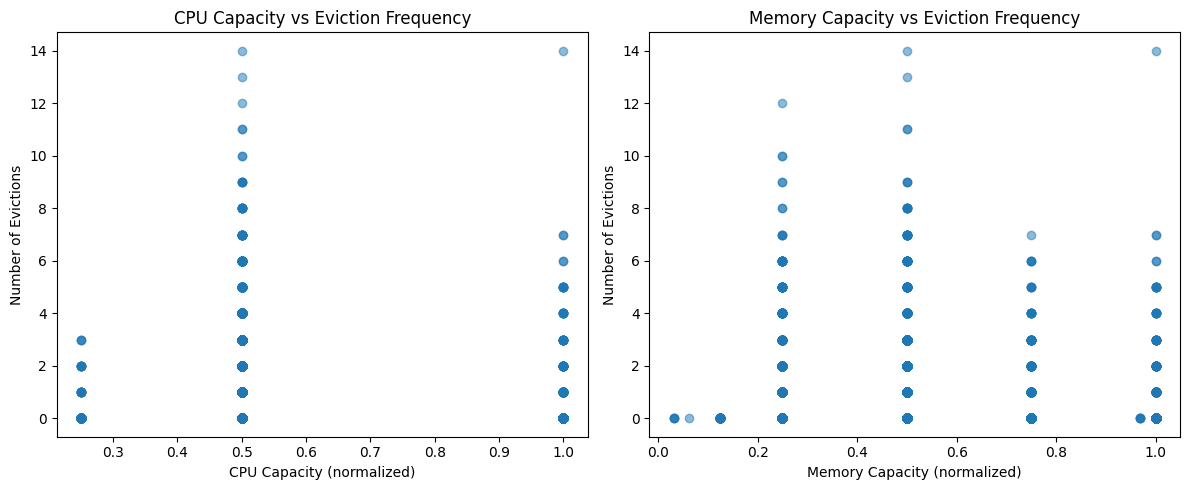

In [34]:
# Convert results for visualization
cpu_capacities = [r[1][0][0] for r in results]
mem_capacities = [r[1][0][1] for r in results]
eviction_counts = [r[1][1] for r in results]

# Create scatter plot
plt.figure(figsize=(12, 5))

# CPU vs Evictions
plt.subplot(1, 2, 1)
plt.scatter(cpu_capacities, eviction_counts, alpha=0.5)
plt.xlabel('CPU Capacity (normalized)')
plt.ylabel('Number of Evictions')
plt.title('CPU Capacity vs Eviction Frequency')

# Memory vs Evictions
plt.subplot(1, 2, 2)
plt.scatter(mem_capacities, eviction_counts, alpha=0.5)
plt.xlabel('Memory Capacity (normalized)')
plt.ylabel('Number of Evictions')
plt.title('Memory Capacity vs Eviction Frequency')

plt.tight_layout()
plt.show()

Correlation coefficient (CPU vs Evictions): 0.000
Correlation coefficient (Memory vs Evictions): 0.043


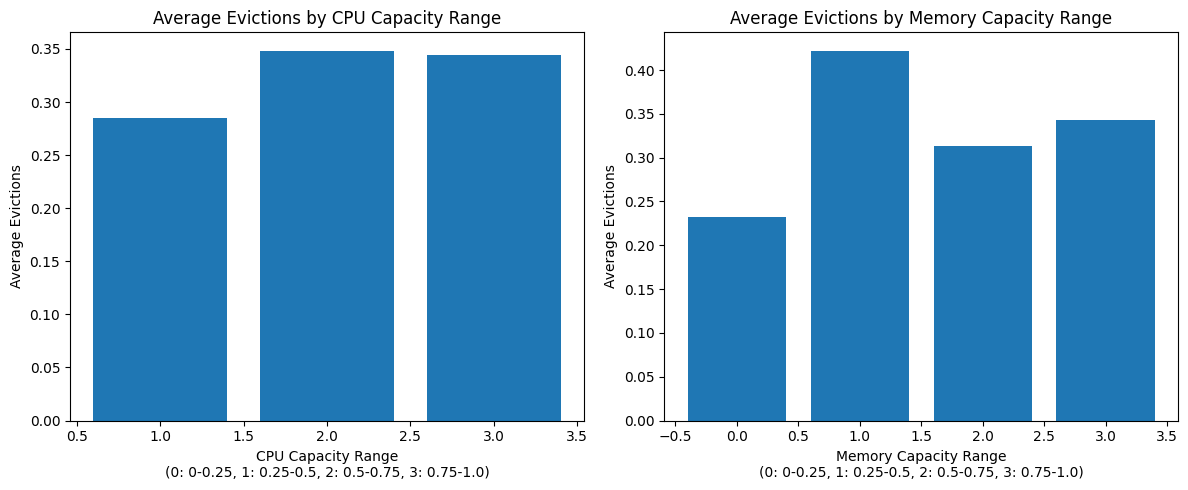

In [35]:
# Calculate correlation coefficients
from collections import defaultdict


cpu_correlation = np.corrcoef(cpu_capacities, eviction_counts)[0,1]
mem_correlation = np.corrcoef(mem_capacities, eviction_counts)[0,1]

print(f"Correlation coefficient (CPU vs Evictions): {cpu_correlation:.3f}")
print(f"Correlation coefficient (Memory vs Evictions): {mem_correlation:.3f}")

# Additional analysis: Group machines by capacity ranges and calculate average evictions
def get_capacity_range(capacity):
    ranges = [(0, 0.25), (0.25, 0.5), (0.5, 0.75), (0.75, 1.0)]
    for i, (low, high) in enumerate(ranges):
        if low <= capacity < high:
            return i
    return len(ranges) - 1

# Group and calculate averages
cpu_groups = defaultdict(list)
mem_groups = defaultdict(list)

for cpu, mem, evict in zip(cpu_capacities, mem_capacities, eviction_counts):
    cpu_groups[get_capacity_range(cpu)].append(evict)
    mem_groups[get_capacity_range(mem)].append(evict)

cpu_avgs = {k: sum(v)/len(v) for k, v in cpu_groups.items()}
mem_avgs = {k: sum(v)/len(v) for k, v in mem_groups.items()}

# Plot average evictions by capacity range
plt.figure(figsize=(12, 5))

# CPU ranges
plt.subplot(1, 2, 1)
plt.bar(cpu_avgs.keys(), cpu_avgs.values())
plt.xlabel('CPU Capacity Range\n(0: 0-0.25, 1: 0.25-0.5, 2: 0.5-0.75, 3: 0.75-1.0)')
plt.ylabel('Average Evictions')
plt.title('Average Evictions by CPU Capacity Range')

# Memory ranges
plt.subplot(1, 2, 2)
plt.bar(mem_avgs.keys(), mem_avgs.values())
plt.xlabel('Memory Capacity Range\n(0: 0-0.25, 1: 0.25-0.5, 2: 0.5-0.75, 3: 0.75-1.0)')
plt.ylabel('Average Evictions')
plt.title('Average Evictions by Memory Capacity Range')

plt.tight_layout()
plt.show()

### Conclusion

Based on this analysis, we can conclude that there is no strong direct relationship between machine CPU/Memory capacity and the frequency of task evictions. This suggests that task evictions are likely driven by other factors such as:

- Workload characteristics (Like the CPU/Memory request of the task and the available resources on the machine)
- Scheduling policies
- Task priority levels

The very low correlation coefficients support this conclusion, indicating that machine capacity alone is not a good predictor of how frequently tasks will be evicted from a machine. The slight variations we see in the average evictions across capacity ranges are likely more reflective of how machines of different capacities are typically used in the cluster rather than a direct causal relationship between capacity and evictions.
This makes sense in the context of Google's cluster management system, where evictions can occur for various reasons beyond just capacity constraints, such as priority preemption or maintenance events.